In [69]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
   
    
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)
    
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    recall_score,
    precision_score,
    accuracy_score
)
    
from sklearn.feature_selection import (
    SelectFromModel,
)

from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")
    

sns.set(style="darkgrid", font_scale=1.4)

RANDOM_STATE = 42

* Загрузим данные

In [70]:
data = pd.read_csv("heart_train.csv")

In [71]:
data = data[(data["Blood sugar"] > data["Blood sugar"].quantile(0.01)) & (data["Blood sugar"] < data["Blood sugar"].quantile(0.99))]
data = data[(data["Heart rate"] > data["Heart rate"].quantile(0.01)) & (data["Heart rate"] < data["Heart rate"].quantile(0.99))]

* Разобьм данные на выборки

In [72]:
X = data.drop(columns=["Heart Attack Risk (Binary)"])
y = data["Heart Attack Risk (Binary)"]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    stratify=y
)

In [74]:
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = data.select_dtypes(include=["object"]).columns.tolist()

In [75]:
class num_cust_transformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        data = X.copy()

        data = data.drop(columns=["Unnamed: 0","id"])

        data[["Stress Level"]] = data[["Stress Level"]].fillna(1)
        data = data.fillna(0)

        data["Sleep Hours Per Day"] = round(data["Sleep Hours Per Day"],2)

        #data = data[(data["Blood sugar"] > data["Blood sugar"].quantile(0.01)) & (data["Blood sugar"] < data["Blood sugar"].quantile(0.99))]
        #data = data[(data["Heart rate"] > data["Heart rate"].quantile(0.01)) & (data["Heart rate"] < data["Heart rate"].quantile(0.99))]

        return data


In [76]:
class cat_cust_transformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        data = X.copy()

        data["Gender"] = data["Gender"].str.replace("1.0","Male").str.replace("0.0","Female")

        return data

### Применим вышенаписанные преобразования для набора данных

In [77]:
gen_num_cols = (
    num_cols,
    [
        num_cust_transformer()
    ],
    {"alias":f"num_col"}
)



In [78]:
gen_cat_cols = (
    cat_cols,
    [
        cat_cust_transformer()
    ],
    {"alias":"cat_col"}
)

In [79]:
preprocess_mapper = DataFrameMapper(
    
    [
        gen_num_cols,
        gen_cat_cols
    ],
    input_df=True,
    df_out=True
)

### Составим кастомный CatBoost

In [80]:
class CustCatBoostClassifier(CatBoostClassifier):

    
    def fit(self, X_train, y_train, **fit_params):
        
        cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()
        
        return super().fit(
            X_train,
            y_train,
            cat_features=cat_features,
            **fit_params
        )

### Составим кастомный селектор

In [81]:
class CustCatBoostSelector(SelectFromModel):

    def transform(self, X):
        
        important_features_indices = list(self.get_support(indices=True))

        
        _X = X.iloc[:, important_features_indices].copy()

        return _X

### Создадим кастомный Pipeline для модели

In [82]:
final_pipe = Pipeline([
    ("preprocessor",preprocess_mapper),
    (
        "selector",
        CustCatBoostSelector(
            estimator=CustCatBoostClassifier(verbose=False),
            max_features=2
        )
    ),
    (
        "model",
        CustCatBoostClassifier(
            learning_rate=0.001,
            random_state=RANDOM_STATE,
            scale_pos_weight=2,
            verbose=False
        )
    )
])

In [ ]:
param_grid = (
    {
        "model__depth":[5],
        "selector__max_features":[3],
        "model__max_bin":[250],
        "model__l2_leaf_reg":[6]
    }
)


gs = GridSearchCV(
    final_pipe,
    param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=3,
    verbose=False

)

In [84]:
gs.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        DataFrameMapper(df_out=True,
                                                        drop_cols=[],
                                                        features=[(['Unnamed: '
                                                                    '0',
                                                                    'Age',
                                                                    'Cholesterol',
                                                                    'Heart '
                                                                    'rate',
                                                                    'Diabetes',
                                                                    'Family '
                                                                    'History',
                                                                    'Smoking',
                                                                    'Obesity',
                                                                    'Alcohol '
                                                                    'Consumption',
                                                                    'Exercise '
                                                                    'Hours Per '
                                                                    'Week',
                                                                    'Diet',
                                                                    'Previous '
                                                                    'Heart '
                                                                    'Problems',
                                                                    'Medication '
                                                                    'Use',
                                                                    'Stress '
                                                                    'Level',
                                                                    'Sedentary '
                                                                    'Hours Per '...
                                                        input_df=True)),
                                       ('selector',
                                        CustCatBoostSelector(estimator=<__main__.CustCatBoostClassifier object at 0x0000013346193E00>,
                                                             max_features=2)),
                                       ('model',
                                        <__main__.CustCatBoostClassifier object at 0x00000133473307D0>)]),
             n_jobs=-1,
             param_grid={'model__depth': [5], 'model__l2_leaf_reg': [6],
                         'model__max_bin': [250],
                         'selector__max_features': [3]},
             scoring='f1', verbose=False)

In [85]:
gs.best_score_

np.float64(0.49323475023372093)

In [86]:
f1_score(y_test, gs.predict(X_test))

0.5156059991892987

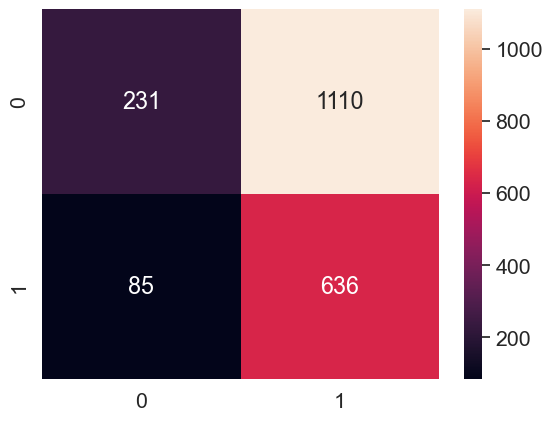

In [87]:
cm = confusion_matrix(y_test, gs.predict(X_test))
sns.heatmap(cm, annot=True, fmt="")
plt.show()

In [88]:
accuracy_score(y_test, gs.predict(X_test))

0.4204655674102813

### Вывод:

В рамках этой записной книжки я реализовал модель CatBoost. Сделал для нее Pipeline. Метрика качества стала лучше чем у прошлой модели.